In [342]:
import numpy as np
import pygame
import pandas as pd
import random
from subprocess import Popen, PIPE, STDOUT
import gymnasium as gym
from gymnasium import spaces
import time

class BasketballEnv(gym.Env):
	#metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

	def __init__(self, render_mode=None ):
		#self.size = size  # The size of the square grid
		
		self.number_to_character = {'0' : 'Alice', '1':'Bob' , '2':'Charlie','3':'Sherlock','4':'?'}
		self.character_to_number = {v: k for k, v in self.number_to_character.items()}
													
		self.number_to_place = {'0' : 'HomeB', '1':'BasketballCourt' , '2':'Downtown','3':'?'}
		self.place_to_number = {v: k for k, v in self.number_to_place.items()}

		self.number_to_item = {'0' : 'Basketball', '1':'Bat','2':'?' }
		self.item_to_number = {v: k for k, v in self.number_to_item.items()}

		self.number_to_crime = {'0' : 'Theft', '1':'Murder','2':'?' }
		self.crime_to_number = {v: k for k, v in self.number_to_crime.items()}

		
		#self._nb_features = 39
		self.score = 0
		self.characters = ['Alice', 'Bob', 'Charlie','Sherlock']
		self.items = ['Basketball','Bat']
		self.places= ['HomeB','BasketballCourt','Downtown']
		self.crimes = ['Theft','Murder']

		self.utilities = {
			'Alice':'1 - angry(Alice);\n',
			'Bob':'3 - (sum(c : citizen) angry(c));\n',
			'Charlie':'if(!alive(Alice)) 1 else 0;\n',
			'Sherlock':'(sum(c : citizen) underArrest(c)); \n',
		}

		self.utilities1 = {
			'Alice':'1 - angry(Alice);\n',
			'Bob':'3 - (sum(c : citizen) angry(c));\n',
			'Charlie':'if(!alive(Alice)) 1 else 0;\n',
			'Sherlock':'(sum(c : citizen) underArrest(c)); \n',
		}

		self.utilities2 = {
			'Alice':'1 - angry(Alice);\n',
			'Bob':'3 - (sum(c : citizen) angry(c));\n',
			'Charlie':'if(!alive(Alice)) 1 else 0;\n',
			'Sherlock':' (sum(p : place) searched(p)); \n',


		}
		"""
		self.characters = ['0','1','2','3']
		self.items = ['0','1']
		self.places= ['0','1','2']
		self.crimes = ['0','1']
		self.utilities = {
			'0':'1 - angry(Alice);\n',
			'1':'3 - (sum(c : citizen) angry(c));\n',
			'2':'if(!alive(Alice)) 1 else 0;\n',
			'3':'(sum(c : citizen) underArrest(c)) + (sum(p : place) searched(p)); \n',
		}
		"""
		self.acting_character = self.characters[0]
		self.additional_utility = None
		self.df_effects = pd.read_csv('basketball_effects_nn.csv')
		self.file = 'rl_planner.txt'
		
		self.randomize_df()
		self.df = self.change_number_to_cat(self.df)
		self.create_file(self.df)
		self.no_solution = 0
		self._nb_features = len(self.df.index)
		# Observations are dictionaries with the agent's and the target's location.
		# Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
		self.observation_space = spaces.Box(
			0,
			5,
			shape = [self._nb_features]
		)

		self.target_feature = None
		self.target_value = None

		

		# We have 4 actions, corresponding to choosing character
		self.action_space = spaces.Discrete(5)

		"""
		The following dictionary maps abstract actions from `self.action_space` to
		the direction we will walk in if that action is taken.
		
		"""
		self._action_to_direction = {
			0: 'char0',
			1: 'char1',
			2: 'char2',
			3: 'ut_char3_1',
			4: 'ut_char3_2',
			
		}


		

		

	def change_number_to_cat(self,row):
		for index,value in row.items():
			if ('acting_character' in index)  or ('has' in index) :
				
				row[index] = self.number_to_character[str(value)]
			if ('suspect' in index) :
				
				row[index] = self.number_to_crime[str(value)]
			elif 'at' in index and 'Bat' not in index:
				row[index] = self.number_to_place[str(value)]

		return row

	def change_cat_to_number(self,row):
		for index,value in row.items():
			if ('acting_character' in index) or ('has' in index):
				if str(value) in self.character_to_number.keys():
					row[index] = self.character_to_number[str(value)]
			if ('suspect' in index) :
				if str(value) in self.crime_to_number.keys():
					row[index] = self.crime_to_number[str(value)]
			elif 'at' in index and 'Bat' not in index:
				if str(value) in self.place_to_number.keys():
					row[index] = self.place_to_number[str(value)]

		return row


	def randomize_df(self):
		

		lists = []
		columns = []

		columns.append("acting_character")
		lists.append(self.characters)

		for c in self.characters:
			c= str(c)
			columns.append(c+"_alive")
			lists.append([0,1])

			columns.append(c+"_underArrest")
			lists.append([0,1])

			columns.append(c+"_angry")
			lists.append([0,1])

			columns.append(c+"_suspect")
			lists.append(self.crimes)

			columns.append(c+"_at")
			lists.append(self.places)
		
			
		for p in self.places:
			p = str(p)
			columns.append(p+"_searched")
			lists.append([0,1])

		characters2 = self.characters + ['?']
		for i in self.items:
			i = str(i)
			columns.append(i+"_has")
			lists.append(characters2 )

		for c in self.crimes:
			for i in self.items:
				for p in self.places:
					columns.append(str(c)+"_"+str(i)+"_"+ str(p) +"_clues")
					lists.append([0,0,0,0,0,0,0,0,0,0,0,1])
		

		d = []
		for l in lists:
			d.append(random.choice(l))

		#print(columns)
		d = ['0','1','0','1','2','2','1','0','0','2','0','1','0','1','2','2','1','0','0','2','2','0','0','0','1','2','0','0','0','0','0','0','0','0','0','0','0','0']
		self.df = pd.Series(data = d, index=columns )
		
		
		
	def create_file(self,row):
		acting_character = self.acting_character
		with open(self.file, 'w') as f:
			f.write("""type item;
type place;
type basketballPlace : place;
type arrestPlace : place;
type crime; 
type citizen : character;
type police : character;
type detective : police;
type inspector : police;

property alive(character : character) : boolean;
property underArrest(character : character) : number;
property angry(character : character) : number;
property searched(place : place) : number;
property suspect(character : character, c : crime) : boolean;
property clue(crime : crime, item : item, place : place) : boolean;
property at(character : character) : place;
property has(item : item) : character;

entity Alice : citizen;
entity Bob : citizen;
entity Charlie : citizen;
entity Sherlock : detective;
entity HomeB : place;
entity BasketballCourt : basketballPlace;
entity Downtown : arrestPlace;
entity Basketball : item;
entity Bat : item;
entity Theft : crime;
entity Murder : crime;

		   """
			)
			
			for char in self.characters:
				if str(row[char+"_alive"]) == '1':
					f.write("alive(" + char  +")  ;\n")
				else:
					f.write("!alive(" + char  +")  ;\n")
				f.write("underArrest(" + char  +") = " + str(row[char+"_underArrest"]) + " ;\n")
				f.write("angry(" + char  +") = " + str(row[char+"_angry"]) + " ;\n")
				if str(row[char+"_suspect"]) != '2' and str(row[char+"_suspect"]) != '?':
					f.write("suspect(" + char + ', '+ str(row[char+"_suspect"]) +")   ;\n")
				f.write("at(" + char  +") = " + str(row[char+"_at"]) + " ;\n")

			
				
			for p in self.places:
				f.write("searched(" + p  +") = " + str(row[p+"_searched"]) + " ;\n")
				

			
			for i in self.items:
				f.write("has(" + i  +") = " + str(row[i+"_has"]) + " ;\n")
				
			clues = [x for x in row.index if 'clues' in x]
			
			for c in clues:
				if str(row[c]) == '1':
					print('!!')
					print(str(row[c]))
					print('!!')
					entities = c.split('_')
					f.write("clue(" + entities[0]+","+entities[1]+","+ entities[2] +")   ;\n")
				#warrtosci postaci
			

				
				

			f.write("""
action travel(character : character, from : place, to : place){
	precondition:
		from != to & 
		at(character) == from &
		alive(character);
	effect:
		at(character) = to;
	consenting: character; 
	observing(c : character) : at(c) == from | at(c) == to; 
};

action arrest(police : police, character : character, place : place, crime : crime){
	precondition: 
		at(police) == place &
		at(character) == place &
		police != character &
		alive(police) &
		alive(character) &
		suspect(character, crime);
	effect:
		underArrest(character) = 1;
	consenting: police;
	observing(a : character) : at(a) == place;
};

action steal(thief : citizen, victim : citizen, item : item, place : place){
	precondition:
		at(thief) == place &
		at(victim) == place &
		has(item) == victim &
		thief != victim &
		alive(thief);
	effect:
		has(item) = thief &
		angry(victim) = 1 &
		clue(Theft, item, place);
	consenting: thief;
	observing(c : character) : (c == thief | c == victim) | (at(c) == place & place != Downtown); // crimes downtown aren't observed
};

action play_basketball(player1 : citizen, player2 : citizen, place : basketballPlace){
	precondition:
		player1 != player2 &
		at(player1) == place &
		alive(player1) &
		at(player2) == place &
		alive(player2) &
		has(Basketball) == player1;
	effect:
		angry(player1) = 0 &
		angry(player2) = 0;
	consenting: player1, player2;
	observing(c : character) : at(c) == place;
};

action kill(killer : citizen, victim : citizen, item : item, place : place){
	precondition:
		killer != victim &
		at(killer) == place &
		at(victim) == place &
		alive(killer) &
		alive(victim) &
		has(item) == killer &
		underArrest(killer) == 0;
	effect:
		!alive(victim) &
		clue(Murder, item, place);
	consenting: killer;
	observing(c : character) : c == killer | (at(c) == place & place != Downtown); 
};
	
action find_clues(police : police, crime : crime, item : item, place : place){
	precondition:
		at(police) == place &
		alive(police)
		&clue(crime, item, place);
	effect:
		searched(place) = 1 &
		if(clue(crime, item, place))
			believes(police, clue(crime, item, place));
	consenting: police;
	observing(c : character) : at(c) == place;
};

action share_clues(police1 : police, police2 : police, crime : crime, item : item, place : place){
	precondition:
		police1 != police2 &
		at(police1) == place &
		alive(police1) &
		at(police2) == place &
		alive(police2) &
		clue(crime, item, place);
	effect:
		believes(police2, clue(crime, item, place));
	consenting: police1;
	observing(c : character) : at(c) == place;
};
 
action suspect_of_crime(police : police, citizen : citizen, crime : crime, item : item, place : place){
	precondition:
		police != citizen &
		at(police) == place &
		alive(police) &
		at(citizen) == place &
		alive(citizen) &
		has(item) == citizen &
		exists(p : place) clue(crime, item, p);
	effect:
		suspect(citizen, crime);
	consenting: police;
	observing(c : character) : at(c) == place;
};

trigger see_has(character : character, other : character, item : item, place : place){
	precondition:
		at(character) == place &
		at(other) == place &
		has(item) == other &
		believes(character, has(item) != other);
	effect:
		believes(character, has(item) = other);
};

trigger see_hasnt(character : character, other : character, item : item, place : place){
	precondition:
		at(character) == place &
		at(other) == place &
		has(item) != other & 
		believes(character, has(item) == other);
	effect:
		believes(character, has(item) = ?);
};

trigger see_at(character : character, other : character, place : place){
	precondition:
		at(character) == place &
		at(other) == place &
		believes(character, at(other) != place);
	effect:
		believes(character, at(other) = place);
};

trigger see_gone(character : character, other : character, place : place){
	precondition:
		at(character) == place &
		at(other) != place &
		believes(character, at(other) == place);
	effect:
		believes(character, at(other) = ?);
};

			""")
		   #.format(acting_character)

			
			
			f.write("utility(): \n ")
			f.write(self.utilities[acting_character])

			
		


			for char in self.characters:
				f.write("utility({}): \n ".format(char))
				f.write(self.utilities[char])
			
			
			f.close()


	def _get_obs(self):
		
		df2 = self.change_cat_to_number(self.df) 
		r = df2.to_numpy(dtype='float32')
		#print(len(r))
		return r
	
	def _get_info(self):
		return {0:'test'}

	def reset(self, seed=None, options=None):
		# We need the following line to seed self.np_random
		super().reset(seed=seed)
		print('reset!')
		#randomize row
		self.randomize_df()
		self.df = self.change_number_to_cat(self.df)
		self.create_file(self.df)
		self.no_solution = 0
		self.score = 0
		self.acting_character = self.characters[0]
		observation = self._get_obs() #turn row into observation
		info = self._get_info() #turn row into info
		self.utilities = self.utilities1
		if self.render_mode == "human":
			self._render_frame()

		return observation, info
	
	
	def load_action(self,file):

		
		p = Popen(['java', '-jar', '..\lib\sabre.jar', '-p', file,'-el',"0","-h","h+",'-c','n',"-tl","3100"], stdout=PIPE, stderr=STDOUT)
		#p = Popen(['java', '-jar', 'lib\sabre.jar', '-p', file,'-el',"0",'-g',"","-tl","1000"], stdout=PIPE, stderr=STDOUT)

		lines=[]
		for line in p.stdout:
			lines.append(str(line, encoding='utf-8'))

		#print(lines)
		return lines[0].replace("\r\n","")

	def do_action(self,args):
		if len(args) > 0 and len(self.df_effects[self.df_effects.action == args[0] ]['effect_function'].values) > 0:
			functions = self.df_effects[self.df_effects.action == args[0] ]['effect_function'].values[0].split(';')
			for function in functions:
				parts = function.split(':')
				
				
				#choosing feature
				feature = parts[0]

				#choosing how feature is changed
				change = parts[1]

				for count,arg in enumerate(args,0):
					
						feature = feature.replace('arg'+str(count),arg)
					
						change = change.replace('arg'+str(count),arg)

				change = change.split("_")
				print(feature)
				print(change)

				

				
				
				if change[0] == "=":
					print("!")
					print(change[1])
					self.df[feature] = change[1]
					print(self.df[feature])
					
					
				elif change[0] == "+":
					self.df[feature] = int(self.df[feature].values[0]) + int(change[1])
				elif change[0] == "-":
					self.df[feature] = int(self.df[feature]) - int(change[1])
		
		
				#print(self.df.index)
				self.df = self.change_cat_to_number(self.df)
			

	def change_state(self,actions):
		
		
		
		
		if 'No solution' not in actions:
			actions = actions.split(') ')
			
			if len(actions) > 0:
				args = actions[0].replace("("," ").replace(")","").replace(",","")
				print(args)
				if ('key_action' not in args) :
					self.do_action(args.split(" "))
				
				return True
		
		return False

	def make_action(self,action):
		if 'ut_char' in action:
			sp = action.split('ut_char')[1]
			char = sp.split('_')[0]
			ut =  sp.split('_')[1]
			self.acting_character = self.number_to_character[str(char)]
			print(self.acting_character)
			if ut == "1":
				self.utilities = self.utilities1
			elif ut == "2":
				self.utilities = self.utilities2
			#self.additional_utility = action
		elif 'char' in action:
			char = action.split('char')[1]
			self.acting_character = self.number_to_character[str(char)]
			print(self.acting_character)
		
		
		else: print("nie ma takiej akcji!")
		
		
		self.create_file(self.change_number_to_cat(self.df))
		start = time.time()

		
		
		self.results = self.load_action(self.file)
		

		end = time.time()
		
		index = 0
		#self.df.loc[index,['results']] = self.results
		#self.df.loc[index,['time']] = (end-start)

		print(self.results)
		self.change_state(self.results)
		
	def get_reward(self):
		#stworzenie targetu na poczatku
		reward = 0
		#czy osiagnelismy target jesli tak to 1
		sum1 = int(self.df['Alice_underArrest']) + int(self.df['Bob_underArrest']) + int(self.df['Charlie_underArrest'])
		sum2 = int(self.df['Alice_angry']) + int(self.df['Bob_angry']) + int(self.df['Charlie_angry'])
		print(sum1)
		print(sum2)
		if sum1 > 0 or sum2 < 2:
		#if str(self.df['Charlie_underArrest']) == '1' and :
			reward = 1
		elif 'No solution' in self.results or 'Time limit' in self.results:
			reward = -0.5
			self.no_solution = self.no_solution+1
		else: 
			self.no_solution = 0
			reward = -1
		#jesli nie to 0
		#jesli nie działa to minus
		#jesli to działa, to ustawienie samemu targetu, też w tabeli
		
		return reward

	def step(self, action):
		# Map the action (element of {0,1,2,3}) to the direction we walk in
		direction = self._action_to_direction[action]
		
		self.make_action(direction)
		
		terminated = False
		reward = self.get_reward()
		if reward > 0 :
			terminated = True
		if self.no_solution > 6:
			terminated = True
		self.score += reward
		observation = self._get_obs()
		info = self._get_info()

		#if self.render_mode == "human":
			

		return observation, reward, terminated, False, info

	def render(self):
		print(self.df)

In [343]:

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gymnasium.wrappers import TimeLimit
#env = gym.make("CartPole-v1")
env = BasketballEnv()
env = TimeLimit(env, max_episode_steps=20)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [344]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

reset!
reset!
Sherlock
Time limit reached.
Time limit reached.
0
2
reset!
Charlie
kill(Charlie, Alice, Bat, Downtown)
kill Charlie Alice Bat Downtown
Alice_alive
['=', '0']
!
0
0
Murder_Bat_Downtown_clues
['=', '1']
!
1
1
0
2
Bob
!!
1
!!
Time limit reached.
Time limit reached.
0
2
Sherlock
!!
1
!!
suspect_of_crime(Sherlock, Charlie, Murder, Bat, Downtown) arrest(Sherlock, Charlie, Downtown, Murder)
suspect_of_crime Sherlock Charlie Murder Bat Downtown
Charlie_suspect
['=', 'Murder']
!
Murder
Murder
0
2
Sherlock
!!
1
!!
arrest(Sherlock, Charlie, Downtown, Murder)
arrest Sherlock Charlie Downtown Murder
Charlie_underArrest
['=', '1']
!
1
1
1
2
reset!
Alice
Time limit reached.
Time limit reached.
0
2
Charlie
kill(Charlie, Alice, Bat, Downtown)
kill Charlie Alice Bat Downtown
Alice_alive
['=', '0']
!
0
0
Murder_Bat_Downtown_clues
['=', '1']
!
1
1
0
2
Charlie
!!
1
!!
No solution exists.
0
2
Bob
!!
1
!!
Time limit reached.
Time limit reached.
0
2
Sherlock
!!
1
!!
find_clues(Sherlock, Murder,

In [345]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [346]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 30)
        self.layer2 = nn.Linear(30, 30)
        #self.layer3 = nn.Linear(30, 30)
        self.layer3 = nn.Linear(30, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        #x = F.relu(self.layer3(x))
        return self.layer3(x)

In [347]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

reset!


In [348]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [352]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 5000

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    print(i_episode)
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

1
reset!
Charlie
kill(Charlie, Alice, Bat, Downtown)
kill Charlie Alice Bat Downtown
Alice_alive
['=', '0']
!
0
0
Murder_Bat_Downtown_clues
['=', '1']
!
1
1
0
2
Sherlock
!!
1
!!
suspect_of_crime(Sherlock, Charlie, Murder, Bat, Downtown) arrest(Sherlock, Charlie, Downtown, Murder)
suspect_of_crime Sherlock Charlie Murder Bat Downtown
Charlie_suspect
['=', 'Murder']
!
Murder
Murder
0
2
Sherlock
!!
1
!!


KeyboardInterrupt: 

In [ ]:

zapisuj modele
ogranicz features
sprwaz jak optymalizowac parametry
sensie liczne warstw itd
zmien by karało za wybranie tej samej postaci
Uprosc działanie przez zapisanie wyników które już byly, może stwórz model który to będzie przewidywał szybciej


SyntaxError: invalid syntax (1114436763.py, line 1)

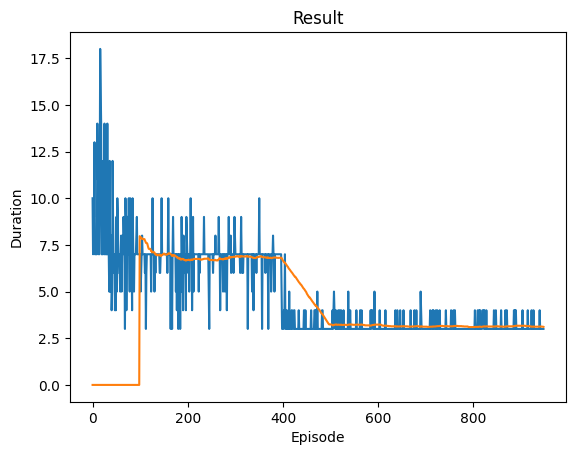

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [351]:
plot_durations(show_result=True)
plt.ioff()
plt.show()
#potrzebowało koło 320 epizodów - z ustalonym d, 4 warstwy ,hidden po 59
# nie udało się, zatrzymałem na koło 260- wciąż ustalony d, lekko bardziej skomplikowany cel(suma zamiast x), 3 warstwy, hidden po 22 - zmien jesli under/overfittinh
# śrdenia zmniejszyła sie do 6 po 200 epizodach - wciaz ustalony d, 3 warsty hidden po 22, ten cel jak w 1 -116 minut
#3 warstwy po 30 - koło 500
# 4 layers, warsty hidden po 30 - powoli sie obniza ale nie warto, działało 200 minut
#relu - juz jest
#dropout - potem jesli zbyt generalizacja
#3 layers by 30, bardziej skomplikowany cel - cały z oryginału
#losowy poczatek
# kara za ta sama postac
# - believes ale tylko przedsatwienie wiedzy
# - believes - wiecej warstw
# - believes - wybór liczby warstw
#jak zapisac model
# - nadawanie utility
# tylko ta postac moze cos zrobic, czy to robi roznice?
#freezing
#inne typy
# - różne wstępne
# - różne cele